# Ejercicio con SVMs de reconocimiento de caras de individuos - Olivetti Dataset

In [21]:
%pylab inline
import IPython
import sklearn
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

print('IPython version:', IPython.__version__)
print('numpy version:', np.__version__)
print('scikit-learn version:', sklearn.__version__)
print('matplotlib version:', matplotlib.__version__)

Populating the interactive namespace from numpy and matplotlib
IPython version: 7.10.1
numpy version: 1.17.3
scikit-learn version: 0.21.3
matplotlib version: 3.1.2


Importamos el dataset Olivetti faces:

In [3]:
from sklearn.datasets import fetch_olivetti_faces

# fetch the faces data
faces = fetch_olivetti_faces()

print(faces.DESCR)

.. _olivetti_faces_dataset:

The Olivetti faces dataset
--------------------------

`This dataset contains a set of face images`_ taken between April 1992 and 
April 1994 at AT&T Laboratories Cambridge. The
:func:`sklearn.datasets.fetch_olivetti_faces` function is the data
fetching / caching function that downloads the data
archive from AT&T.

.. _This dataset contains a set of face images: http://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html

As described on the original website:

    There are ten different images of each of 40 distinct subjects. For some
    subjects, the images were taken at different times, varying the lighting,
    facial expressions (open / closed eyes, smiling / not smiling) and facial
    details (glasses / no glasses). All the images were taken against a dark
    homogeneous background with the subjects in an upright, frontal position 
    (with tolerance for some side movement).

**Data Set Characteristics:**

    =================   ===========

Echamos un vistazo a los datos. `faces.images` tiene 400 imágenes de caras, cada una de ellas compuesta por una matriz de 64x64 pixels. `faces.data` tiene los mismos datos, pero en filas de 4096 atributos en vez de las matrices (4096 = 64x64):

In [4]:
print(faces.keys())
print(faces.images.shape)
print(faces.data.shape)
print(faces.target.shape)

dict_keys(['data', 'images', 'target', 'DESCR'])
(400, 64, 64)
(400, 4096)
(400,)


No tenemos que escalar los atributos, porque los datos ya están normalizados:

In [5]:
print(np.max(faces.data))
print(np.min(faces.data))
print(np.mean(faces.data))

1.0
0.0
0.5470426


Vamos a mostrar las primeras 20 imágenes. Tenemos 40 personas con 10 imágenes diferentes para cada una de ellas:

In [6]:
def print_faces(images, target, top_n):
    # Configuramos el tamaño de las imágenes en pulgadas
    fig = plt.figure(figsize=(12, 12))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
    for i in range(top_n):
        # Visualizamos las imágenes en una matriz de 20x20
        p = fig.add_subplot(20, 20, i + 1, xticks=[], yticks=[])
        p.imshow(images[i], cmap=plt.cm.bone)
        
        # Cargamos las imágenes con el valor objetivo
        p.text(0, 14, str(target[i]))
        p.text(0, 60, str(i))

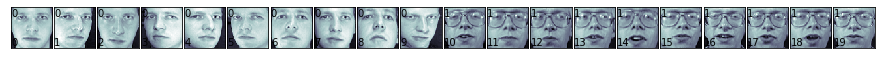

In [8]:
print_faces(faces.images, faces.target, 20)

Mostramos ahora todas las caras en una matriz de 20x20, y para cada una de ellas, ponemos el valor objetivo en la esquina superor izquierda y su índice en la esquina inferior izquierda (este comando puede tardar unos segundos):

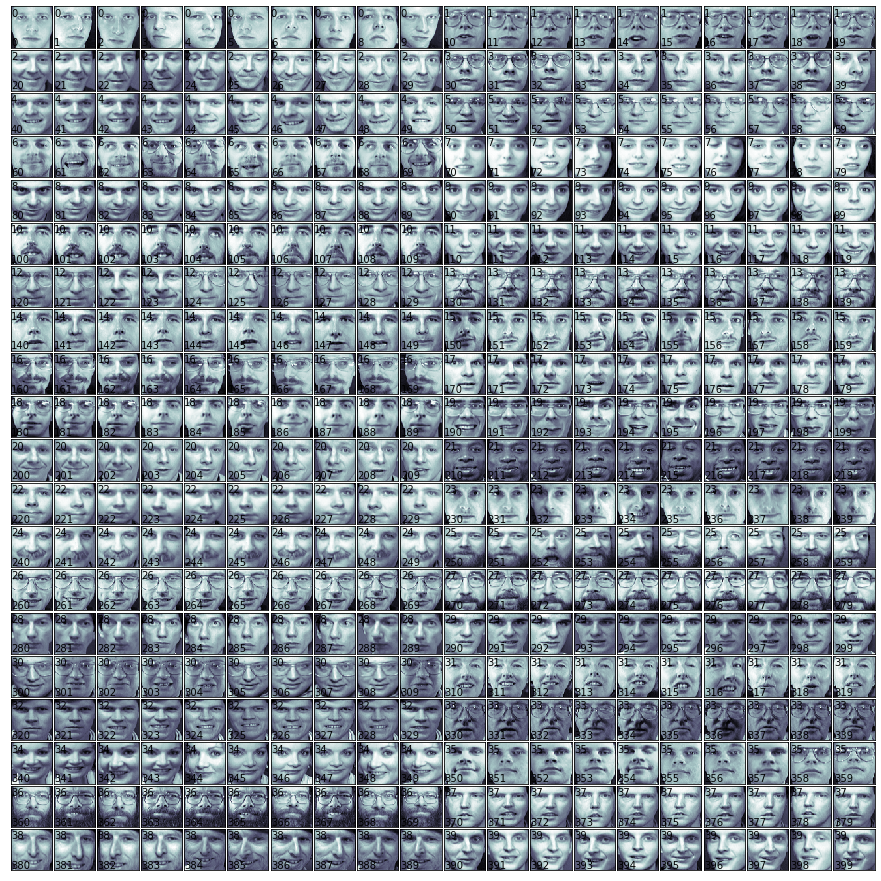

In [9]:
print_faces(faces.images, faces.target, 400)

Intentaremos ahora construir un clasificador cuyo modelo sea un hiperplano que separe las instancias de una clase del resto. Support Vector Machines será un candidato ideal, ya que seleccionará aquellos que pasen por los huecos más anchos posibles entre las instancias de diferentes clases. Las nuevas instancias se clasificarán como pertenecientes a una determinada categoría basándose en el lado de la superficie en el que caigan.

Vamos a importar la clase SVC del módulo `sklearn.svm`, donde SVC significa *Support Vector Classifier*:

In [10]:
from sklearn.svm import SVC
svc_1 = SVC(kernel='linear')
print(svc_1)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)


In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    faces.data, faces.target, test_size=0.25, random_state=42)

Ahora hacemos una validación cruzada de 5 iteraciones para evaluar nuestro resultado. Estamos utilizando nuevas clases de Scikit-Learn para realizarlo ([KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) y [cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html)), tal y como vemos en el siguietne código

In [12]:
from sklearn.model_selection import cross_val_score, KFold
# Importamos el calculo del error estandar de la media
from scipy.stats import sem

def evaluate_cross_validation(clf, X, y, K):
    """
    Instancia un validador cruzado y realiza la evaluación
    del modelo suministrado con K iteraciones del validador
    """
    # Creamos un iterador para k-iteraciones de validación
    cv = KFold(K, shuffle=True, random_state=42)
    # Por defecto, la métrica utilizada es la que devuelve el estimador utilizado (precisión)
    scores = cross_val_score(clf, X, y, cv=cv)
    print(scores)
    print(("Precisión media: {0:.3f} (+/-{1:.3f})").format(
        np.mean(scores), sem(scores)))

In [13]:
evaluate_cross_validation(svc_1, X_train, y_train, 5)

[0.96666667 0.88333333 0.96666667 0.95       0.85      ]
Precisión media: 0.923 (+/-0.024)


In [14]:
from sklearn import metrics

def train_and_evaluate(clf, X_train, X_test, y_train, y_test):
    """
    Entrena el modelo clasificador suministrado, realiza la
    predicción sobre el test set y evalua el resultado de la clasificación.
    """

    clf.fit(X_train, y_train)

    print("Precisión en el training set: ", clf.score(X_train, y_train))
    print("Precisión en el testing set: ", clf.score(X_test, y_test))

    y_pred = clf.predict(X_test)

    cm = metrics.confusion_matrix(y_test, y_pred)

    print("Informe de clasificación: \n", metrics.classification_report(y_test, y_pred))
    print("Matriz de confusión: \n", cm)
    return cm

In [17]:
cm = train_and_evaluate(svc_1, X_train, X_test, y_train, y_test)

Precisión en el training set:  1.0
Precisión en el testing set:  0.97
Informe de clasificación: 
               precision    recall  f1-score   support

           0       1.00      0.50      0.67         4
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         1
           7       1.00      0.86      0.92         7
           8       1.00      1.00      1.00         2
           9       1.00      1.00      1.00         3
          10       1.00      1.00      1.00         3
          11       1.00      1.00      1.00         4
          12       1.00      1.00      1.00         2
          13       1.00      1.00      1.00         1
          14       1.00      1.00      1.00         3
          15       1.00      1.00    

La matriz de confusión será grande, ya que tenemos 40 categorías, pero dada la precisión obtenida nos dará de una manera muy rápida y visual un vistazo sobre los pocos errores de clasificación que hemos tenido.

In [18]:

plt.figure(figsize=(40,40))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square=True, cmap="YlGnBu")
plt.ylabel('Valor real')
plt.xlabel('Valor predicho')
all_sample_title = 'Matriz de confusión'
plt.title(all_sample_title, size = 15)

NameError: name 'sns' is not defined

Como puede verse, el rendimiento del modelo es bastante bueno. Vamos ahora a tratar un problema diferente con el mismo modelo:

## Reconocimiento de personas con o sin gafas

Ya que el dataset no incorpora per se esta información, vamos a marcar de manera manual (supervisión humana) las imágenes:

In [45]:
# Almacemos en una lista las coordenadas de los índices de las personas que tienen gafas
glasses = [
	(10, 19), (30, 32), (37, 38), (50, 59), (63, 64),
	(69, 69), (120, 121), (124, 129), (130, 139), (160, 161),
	(164, 169), (180, 182), (185, 185), (189, 189), (190, 192),
	(194, 194), (196, 199), (260, 269), (270, 279), (300, 309),
	(330, 339), (358, 359), (360, 369)
]

Creamos ahora el training y test set para este nuevo problema. Primero, creamos una nueva función Python para crear el nuevo vector de targets:

In [46]:
def create_target(segments):
    """
    Crea un nuevo vector de targets considerando una categoría binaria
    a partir de una lista que marca los segmentos en el antiguo vector de targets
    """
    # Creamos un nuevo array de objetivos inicializado a cero
    y = np.zeros(faces.target.shape[0])
    # Activamos un uno en los segmentos específicos, como una forma de máscara
    for (start, end) in segments:
        y[start:end + 1] = 1
    return y

Creamos el nuevo vector de objetivos invocando a nuestra nueva función y hacemos el reparto entre test y training:

In [47]:
target_glasses = create_target(glasses)

# Reservamos un 25% de los datos para el testing final
X_train, X_test, y_train, y_test = train_test_split(
        faces.data, target_glasses, test_size=0.25, random_state=42)

In [48]:
# Instanciamos un nuevo modelo SVM para este problema 
svc_2 = SVC(kernel='linear')

# Invocamos a la función que creamos anteriormente
# para hacer la evaluación de la validación cruzada
evaluate_cross_validation(svc_2, X_train, y_train, 5)

# Finalmente, entrenamos el modelo y evaluamos con respecto
# al testing set
train_and_evaluate(svc_2, X_train, X_test, y_train, y_test)

[0.96666667 0.98333333 0.98333333 0.98333333 0.96666667]
Mean Score: 0.977 (+/-0.004)
Precisión en el training set:  1.0
Precisión en el testing set:  0.96
Informe de clasificación: 
               precision    recall  f1-score   support

         0.0       1.00      0.95      0.97        75
         1.0       0.86      1.00      0.93        25

    accuracy                           0.96       100
   macro avg       0.93      0.97      0.95       100
weighted avg       0.97      0.96      0.96       100

Confusion Matrix: 
 [[71  4]
 [ 0 25]]


array([[71,  4],
       [ 0, 25]])

La clasificación es casi perfecta. Vamos a separar ahora 10 imágenes diferentes para la misma persona, a veces con gafas y a veces sin ellas. Haciendo esto trataremos de descartar que nuestro modelo esté memorizando caras en vez de las características de la imagen relacionadas con las gafas en sí. 

En particular, separaremos a la persona con índice del 30 al 39, y entrenaremos y evaluaremos para las 390 instancias restantes. Una vez hecho eso, volveremos a evaluar las 10 instancias que hemos separado:

In [50]:
# Separamos a una persona en concreto
X_test = faces.data[30:40]
y_test = target_glasses[30:40]

# Capturamos las dimensiones
print(y_test.shape[0])

# Usamos las dimensiones calculadas para enmascarar y filtrar
# los datos de test del training set
select = np.ones(target_glasses.shape[0])
select[30:40] = 0
X_train = faces.data[select == 1]
y_train = target_glasses[select == 1]

# Comprobamos las dimensiones del training set
print(y_train.shape[0])

10
390


Finalmente, entrenamos un nuevo modelo SVM para este caso:

In [51]:
svc_3 = SVC(kernel='linear')
train_and_evaluate(svc_3, X_train, X_test, y_train, y_test)
y_pred = svc_3.predict(X_test)

Precisión en el training set:  1.0
Precisión en el testing set:  0.9
Informe de clasificación: 
               precision    recall  f1-score   support

         0.0       0.83      1.00      0.91         5
         1.0       1.00      0.80      0.89         5

    accuracy                           0.90        10
   macro avg       0.92      0.90      0.90        10
weighted avg       0.92      0.90      0.90        10

Confusion Matrix: 
 [[5 0]
 [1 4]]


Mostramos ahora las caras que hemos reservado para probar, y su categoría predicha.

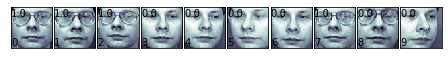

In [53]:
eval_faces = [np.reshape(a, (64, 64)) for a in X_test]
print_faces(eval_faces, y_pred, 10)

Vemos que, tal y como adelantaba la matriz de confusión, que la cara número 8 está incorrectamente clasificada como "sin gafas", probablemente porque los ojos están cerrados.